<a href="https://colab.research.google.com/github/noelmtv/Colab-Learning/blob/main/Portfolio_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries#
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
!pip install fredapi
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
#define the list of tickers#
tickers = [
"DAL","UAL", "AAL", "LUV", "ALK", "JBLU", "ULCC", "ALGT", "SKYW", "RYAAY", "AC.TO"
]


Airline Tickers: "DAL","UAL", "AAL", "LUV", "ALK", "JBLU", "ULCC", "ALGT", "SKYW", "RYAAY", "AC.TO"

Telecoms: "T", "VZ", "CMCSA", "CHTR", "LUMN", "VOD", "GSAT", "BCE"

Beer: "TAP", "BUD", "SAM", "STZ", "HEINY", "HKHHY", "FMX", "CABGY"

In [3]:
#SET THE END DATE TO TODAY#
end_date = datetime.today()

In [4]:
#Set start date#
start_date = end_date - timedelta(days=10*365)
print(start_date)

2015-12-08 04:29:18.880729


In [5]:
#download adjusted close prices#
#This is done because you dont want to underweight a stock that pays out dividends#
adj_close_df = pd.DataFrame()
print(adj_close_df.columns)

RangeIndex(start=0, stop=0, step=1)


In [6]:
# Download the prices for each ticker#
#yFinance has by default adjusted Open/High/Low/Close, hence no need to specify 'Adj Close'
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data["Close"]

/tmp/ipython-input-1957566553.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1957566553.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1957566553.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1957566553.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-19575

In [7]:
# Store the output to your google drive
adj_close_df.to_csv('/content/drive/My Drive/df.csv', index=False)
print(adj_close_df)

                  DAL         UAL        AAL        LUV        ALK       JBLU  \
Date                                                                            
2015-12-08  44.445541   58.650002  42.574005  40.219334  79.169670  26.100000   
2015-12-09  43.773579   57.860001  41.713924  39.737137  77.218628  25.330000   
2015-12-10  45.338497   59.529999  42.134415  40.406864  78.004601  25.440001   
2015-12-11  43.570232   57.029999  40.223125  38.772732  76.534378  23.440001   
2015-12-14  44.365959   57.299999  39.917313  39.085262  75.961082  23.120001   
...               ...         ...        ...        ...        ...        ...   
2025-11-28  64.099998  101.959999  14.050000  34.810001  42.860001   4.570000   
2025-12-01  64.150002  101.120003  13.960000  34.770000  42.520000   4.470000   
2025-12-02  65.139999  104.379997  14.240000  35.430000  42.660000   4.560000   
2025-12-03  67.489998  108.480003  14.560000  35.680000  45.369999   4.710000   
2025-12-04  67.239998  104.7

**Step 3: Calculate the Lognormal Returns**

In [8]:
#Calculate the Lognormal returns for each ticker#
#Use lognormal because the returns are additive#
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [9]:
#drop missing values#
log_returns = log_returns.dropna()

**Step 4: Calculate the Covariance Matrix**

In [10]:
#helps us calculate standard deviation/risk in the most optimal way possible#
# MULTIPLY BY 252 TO ANNUALISE THE DAILY RETURNS#

cov_matrix = log_returns.cov() * 252
print(cov_matrix)

            DAL       UAL       AAL       LUV       ALK      JBLU      ULCC  \
DAL    0.164066  0.173947  0.165641  0.104648  0.130862  0.142296  0.161234   
UAL    0.173947  0.230875  0.195923  0.119928  0.150220  0.172868  0.197162   
AAL    0.165641  0.195923  0.229882  0.122642  0.141816  0.176954  0.190378   
LUV    0.104648  0.119928  0.122642  0.133935  0.098727  0.129623  0.133277   
ALK    0.130862  0.150220  0.141816  0.098727  0.164654  0.143788  0.161691   
JBLU   0.142296  0.172868  0.176954  0.129623  0.143788  0.352299  0.252369   
ULCC   0.161234  0.197162  0.190378  0.133277  0.161691  0.252369  0.448956   
ALGT   0.144234  0.169335  0.164791  0.125416  0.138567  0.197737  0.227583   
SKYW   0.114720  0.133832  0.128310  0.089093  0.106706  0.125459  0.140618   
RYAAY  0.077730  0.086693  0.087578  0.058165  0.067719  0.085684  0.085139   
AC.TO  0.092672  0.107730  0.106159  0.068297  0.079191  0.099584  0.106675   

           ALGT      SKYW     RYAAY     AC.TO  
DAL

**Section 5: Define portfolio Performance Metrics**

In [11]:
#calculate the portfolio standard deviation#
def standard_deviation(weights,cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)


In [12]:
#Calculate Expected Returns using historical returns#
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [13]:
# calculate the Sharpe Ratio

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)


In [14]:
# Get and define your FRED API key from secrets tab in Colab
from google.colab import userdata
fred_api_key = userdata.get('fred_api_key')

# Get the risk free rate
from fredapi import Fred
fred = Fred(api_key = fred_api_key)
ten_year_treasury_rate = fred.get_series('GS10')/100

#Set the risk free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)


0.0409


In [15]:
#Define the function to minimize (Negative Sharpe Ratio)
# In the case of scipy, there is no direct method to find the maximum value of a function so you gotta flip it.

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

    print(neg_sharpe_ratio)

In [16]:
#Set the constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = [(0,0.7) for _ in range(len(tickers))]

In [17]:
#Set the initial weights
initial_weights = np.array([1/len(tickers)] * len(tickers))
print(initial_weights)

[0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]


In [18]:
#optimize the weights to maximise the sharpe ratio

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate),
                             method='SLSQP', bounds=bounds, constraints=constraints)
optimized_weights = optimized_results.x

# Print the optimized weights
print("Optimized Weights:")
print(optimized_weights)

Optimized Weights:
[4.19731784e-14 2.38048885e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.00000000e-01 6.19511146e-02 0.00000000e+00]


**Analyse the optimal portfolio**

In [19]:
# Display the analytics of the optimal portfolio

for ticker, weight in zip(tickers, optimized_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimized_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimized_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimized_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Optimal Portfolio Return: {optimal_portfolio_return:.4f}")
print(f"Optimal Portfolio Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Optimal Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

DAL: 0.0000
UAL: 0.2380
AAL: 0.0000
LUV: 0.0000
ALK: 0.0000
JBLU: 0.0000
ULCC: 0.0000
ALGT: 0.0000
SKYW: 0.7000
RYAAY: 0.0620
AC.TO: 0.0000

Optimal Portfolio Return: 0.1264
Optimal Portfolio Volatility: 0.4034
Optimal Sharpe Ratio: 0.2119


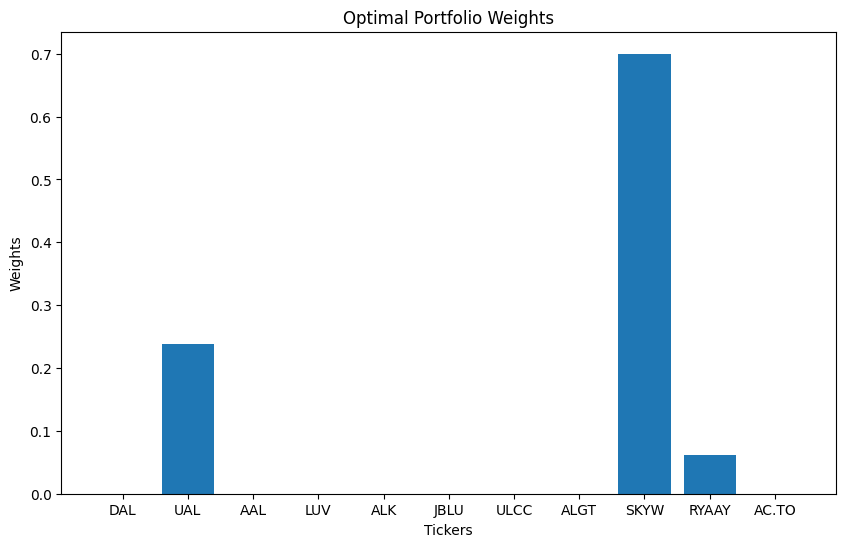

In [20]:
#display the final portfolio in a plot

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimized_weights)
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.title('Optimal Portfolio Weights')
plt.show()